## Imports and Setup
  This cell imports all the necessary libraries for the project, including NumPy, Matplotlib, and scikit-learn, and sets a random seed for reproducibility.                                       

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
import matplotlib.colors as mcolors
import warnings

if not os.path.exists('images'):
    os.makedirs('images')
    print("Created 'images' directory.")
else:
    print("'images' directory already exists.")

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print("Imports and basic setup completed.")

'images' directory already exists.
Imports and basic setup completed.


## Data Loading and Preprocessing                             
  Loads the handwritten digits dataset, scales the features to a range between 0 and 1, and splits the data into training, validation, and final test sets.

In [13]:

digits = load_digits()
X = digits.data
y = digits.target

print(f"Digits dataset loaded: {X.shape[0]} samples, {X.shape[1]} features.")
print(f"Number of classes: {len(np.unique(y))}")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(f"Data scaled using {type(scaler).__name__}.")

# initial train / final test
X_train_init, X_test, y_train_init, y_test, X_train_init_orig, X_test_orig = train_test_split(
    X_scaled, y, X, test_size=0.2, random_state=42, stratify=y
)
print(f"Initial data split: Initial Train ({X_train_init.shape[0]}), Final Test ({X_test.shape[0]})")

# final train / validation
X_train_final, X_val, y_train_final, y_val, X_train_final_orig, X_val_orig = train_test_split(
    X_train_init, y_train_init, X_train_init_orig,
    test_size=0.25, random_state=42, stratify=y_train_init
)

print(f"Train/Validation split: Final Train ({X_train_final.shape[0]}), Validation ({X_val.shape[0]})")
print("Digits data prepared and split into Train/Validation/Test sets.")
print("-" * 30)


Digits dataset loaded: 1797 samples, 64 features.
Number of classes: 10
Data scaled using MinMaxScaler.
Initial data split: Initial Train (1437), Final Test (360)
Train/Validation split: Final Train (1077), Validation (360)
Digits data prepared and split into Train/Validation/Test sets.
------------------------------


## SOM Training                                               
  Defines the hyperparameters for two Self-Organizing Maps (a small 4x4 and a large 20x20) and then trains both models on the final training data, printing the quantization error for each.

In [14]:
som_grid_size_small = (4, 4)
som_grid_size_large = (20, 20)
n_features = X_train_final.shape[1]

sigma_small = 1.0
lr_small = 0.5
iterations_small = 10000
init_method_small = "PCA"

sigma_large = 3.0
lr_large = 0.5
iterations_large = 15000
init_method_large = "Random"

print("SOM Hyperparameters defined.")
print(f" Small (4x4): Sigma={sigma_small}, LR={lr_small}, Iter={iterations_small}, Init={init_method_small}")
print(f" Large (20x20): Sigma={sigma_large}, LR={lr_large}, Iter={iterations_large}, Init={init_method_large}")
print("-" * 30)

# Train 4x4 SOM
print("\n--- Configuring and Training 4x4 SOM ---")
print(f"Grid: {som_grid_size_small}, Sigma: {sigma_small}, LR: {lr_small}, Iter: {iterations_small}, Init: {init_method_small}")

som_small = MiniSom(x=som_grid_size_small[0], y=som_grid_size_small[1],
                    input_len=n_features, sigma=sigma_small,
                    learning_rate=lr_small,
                    neighborhood_function='gaussian', random_seed=42)

if init_method_small == "PCA":
    print("Initializing weights using PCA...")
    warnings.filterwarnings("ignore")
    som_small.pca_weights_init(X_train_final)
else:
    print("Initializing weights randomly...")
    som_small.random_weights_init(X_train_final)

print(f"Training for {iterations_small} iterations...")
som_small.train_random(X_train_final, iterations_small, verbose=False)

qe_small_train = som_small.quantization_error(X_train_final)
qe_small_val = som_small.quantization_error(X_val)
print("Training completed!")
print(f"Quantization Error (Small SOM): Train QE = {qe_small_train:.4f}, Validation QE = {qe_small_val:.4f}")
print("-" * 30)

# Train 20x20 SOM
print("\n--- Configuring and Training 20x20 SOM ---")
print(f"Grid: {som_grid_size_large}, Sigma: {sigma_large}, LR: {lr_large}, Iter: {iterations_large}, Init: {init_method_large}")

som_large = MiniSom(x=som_grid_size_large[0], y=som_grid_size_large[1],
                    input_len=n_features, sigma=sigma_large,
                    learning_rate=lr_large,
                    neighborhood_function='gaussian', random_seed=42)

if init_method_large == "PCA":
    print("Initializing weights using PCA...")
    som_large.pca_weights_init(X_train_final)
else:
    print("Initializing weights randomly...")
    som_large.random_weights_init(X_train_final)

print(f"Training for {iterations_large} iterations...")
som_large.train_random(X_train_final, iterations_large, verbose=False)

qe_large_train = som_large.quantization_error(X_train_final)
qe_large_val = som_large.quantization_error(X_val)
print("Training completed!")
print(f"Quantization Error (Large SOM): Train QE = {qe_large_train:.4f}, Validation QE = {qe_large_val:.4f}")
print("-" * 30)


SOM Hyperparameters defined.
 Small (4x4): Sigma=1.0, LR=0.5, Iter=10000, Init=PCA
 Large (20x20): Sigma=3.0, LR=0.5, Iter=15000, Init=Random
------------------------------

--- Configuring and Training 4x4 SOM ---
Grid: (4, 4), Sigma: 1.0, LR: 0.5, Iter: 10000, Init: PCA
Initializing weights using PCA...
Training for 10000 iterations...
Training completed!
Quantization Error (Small SOM): Train QE = 1.5233, Validation QE = 1.5735
------------------------------

--- Configuring and Training 20x20 SOM ---
Grid: (20, 20), Sigma: 3.0, LR: 0.5, Iter: 15000, Init: Random
Initializing weights randomly...
Training for 15000 iterations...
Training completed!
Quantization Error (Large SOM): Train QE = 1.1078, Validation QE = 1.2183
------------------------------


## Visualization Function
  Defines a reusable function, visualize_som_clusters, to generate visualizations for a trained SOM, including a hit map of neuron activations and a grid displaying sample images mapped to each neuron.

In [15]:
def visualize_som_clusters(som, X_scaled_map, y_map, X_orig_display, grid_size, title):
    print(f"\n--- Visualizing SOM Clusters: {title} ---")
    rows, cols = grid_size
    mapped_positions_cr = [som.winner(x) for x in X_scaled_map]

    neuron_map = {(c, r): [] for c in range(cols) for r in range(rows)}
    for idx, pos_cr in enumerate(mapped_positions_cr):
        if 0 <= pos_cr[0] < cols and 0 <= pos_cr[1] < rows:
            neuron_map[pos_cr].append(idx)

    # 1. Hit map
    plt.figure(figsize=(max(6, cols * 0.6), max(6, rows * 0.6)))
    plt.title(f'Hit Map - {title} ({rows}x{cols})')
    hit_map = np.zeros((rows, cols), dtype=int)
    for pos_cr, indices in neuron_map.items():
        col, row = pos_cr
        if 0 <= row < rows and 0 <= col < cols:
            hit_map[row, col] = len(indices)

    print(f"Hit Map Analysis ({title}):")
    print(f" Min hits per neuron = {np.min(hit_map)}")
    print(f" Max hits per neuron = {np.max(hit_map)}")
    print(f" Avg hits per neuron = {np.mean(hit_map):.2f}")

    im = plt.imshow(hit_map, cmap='viridis', origin='upper', interpolation='nearest')
    plt.colorbar(im, label='Number of Samples Mapped')

    dead_neurons = []
    plotted_legend = False
    for r in range(rows):
        for c in range(cols):
            if hit_map[r, c] == 0:
                pos_cr = (c, r)
                dead_neurons.append(pos_cr)
                plt.scatter(c, r, marker='x', color='red', s=60,
                            label='Dead Neuron' if not plotted_legend else "")
                plotted_legend = True

    if dead_neurons:
        plt.legend(fontsize=8)

    plt.xticks(np.arange(cols))
    plt.yticks(np.arange(rows))
    plt.xlabel("Neuron Column Index")
    plt.ylabel("Neuron Row Index")
    plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle=':')
    
    # --- NEW: Save Hit Map Figure ---
    safe_title = title.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").lower()
    save_path_hitmap = os.path.join('images', f'som_hitmap_{safe_title}.png')
    plt.savefig(save_path_hitmap)
    print(f"Saved Hit Map to: {save_path_hitmap}")
    # --- END NEW ---
    plt.show()

    # 2. Sample images + majority label per neuron
    print(f"\nGenerating sample images plot for {title}...")
    fig_samples, axes = plt.subplots(rows, cols,
                                     figsize=(max(10, cols), max(10, rows)),
                                     subplot_kw={'xticks': [], 'yticks': []})
    fig_samples.suptitle(f'Sample Images & Majority Label per Neuron - {title}', fontsize=16)

    neuron_labels_map = {}
    for r in range(rows):
        for c in range(cols):
            if rows > 1 and cols > 1:
                ax = axes[r, c]
            elif rows == 1 and cols == 1:
                ax = axes
            else:
                ax = axes[max(r, c)]

            pos_cr = (c, r)
            if pos_cr in neuron_map and neuron_map[pos_cr]:
                indices = neuron_map[pos_cr]
                labels_mapped = y_map[indices]
                neuron_labels_map[pos_cr] = labels_mapped.tolist()

                sample_idx = indices[0]
                img = X_orig_display[sample_idx].reshape(8, 8)
                ax.imshow(img, cmap='binary')

                if labels_mapped.size > 0:
                    unique_labels, counts = np.unique(labels_mapped, return_counts=True)
                    majority_label = unique_labels[np.argmax(counts)]
                    label_counts_str = "/".join([f"{lbl}:{cnt}" for lbl, cnt in zip(unique_labels, counts)])
                    fontsize = max(4, 10 - max(rows, cols)//2)
                    ax.set_title(f"({c},{r}): N={len(indices)}\nMaj={majority_label} ({label_counts_str})",
                                 fontsize=fontsize)
                else:
                    ax.set_title(f"({c},{r}): N=0\nLbl=?",
                                 fontsize=max(4, 10 - max(rows, cols)//2))
            else:
                ax.set_title(f"({c},{r}): Dead", fontsize=max(4, 10 - max(rows, cols)//2))
                ax.set_facecolor('lightgrey')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    save_path_samples = os.path.join('images', f'som_samples_{safe_title}.png')
    plt.savefig(save_path_samples)
    print(f"Saved Samples Plot to: {save_path_samples}")
    plt.show()

    return neuron_labels_map, dead_neurons

## Training Data Visualization                                   
  Uses the function from the previous cell to visualize the clustering results of both the 4x4 and 20x20 SOMs based on the training data, helping to understand how each network organized the digits.


Visualizing 4x4 SOM based on FINAL Training Data:

--- Visualizing SOM Clusters: 4x4 Grid (Final Train Data) ---
Hit Map Analysis (4x4 Grid (Final Train Data)):
 Min hits per neuron = 30
 Max hits per neuron = 116
 Avg hits per neuron = 67.31
Saved Hit Map to: images/som_hitmap_4x4_grid_final_train_data.png


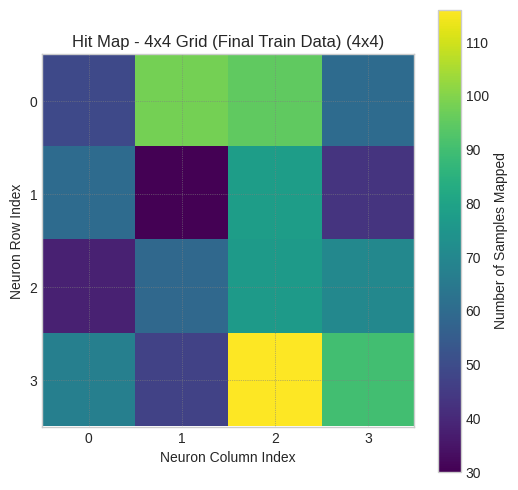


Generating sample images plot for 4x4 Grid (Final Train Data)...
Saved Samples Plot to: images/som_samples_4x4_grid_final_train_data.png


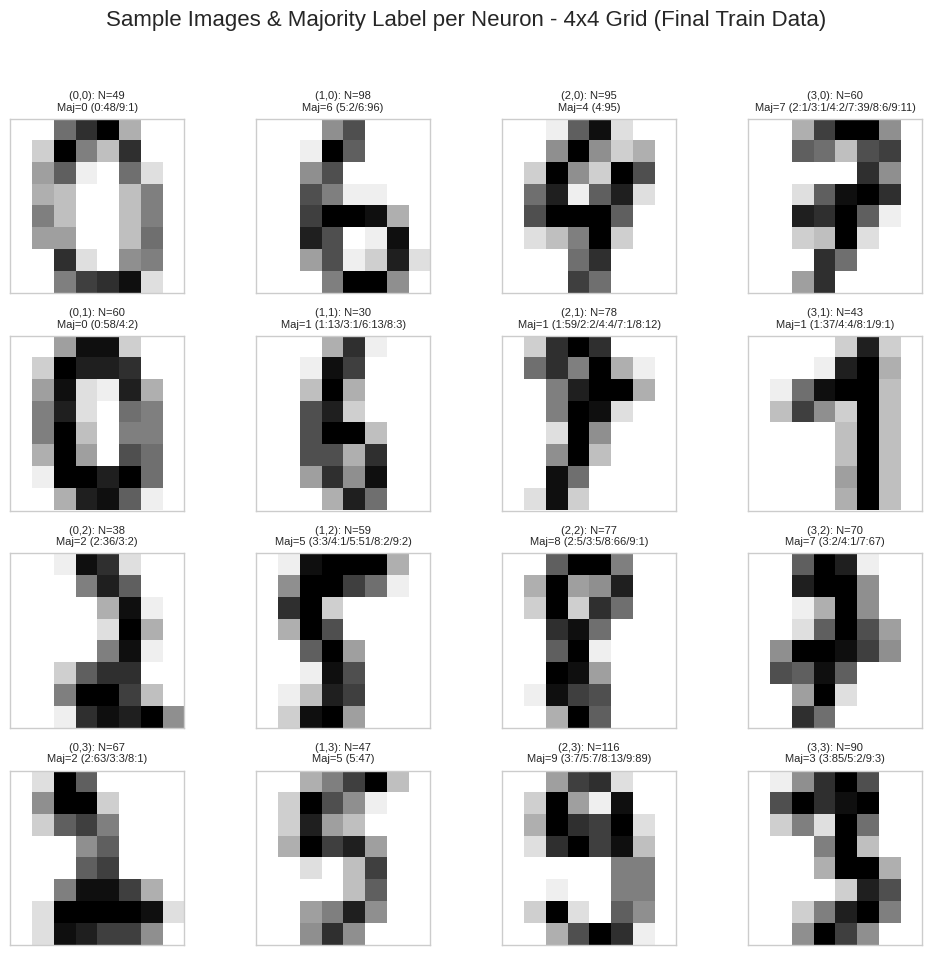

------------------------------

Visualizing 20x20 SOM based on FINAL Training Data:

--- Visualizing SOM Clusters: 20x20 Grid (Final Train Data) ---
Hit Map Analysis (20x20 Grid (Final Train Data)):
 Min hits per neuron = 0
 Max hits per neuron = 14
 Avg hits per neuron = 2.69
Saved Hit Map to: images/som_hitmap_20x20_grid_final_train_data.png


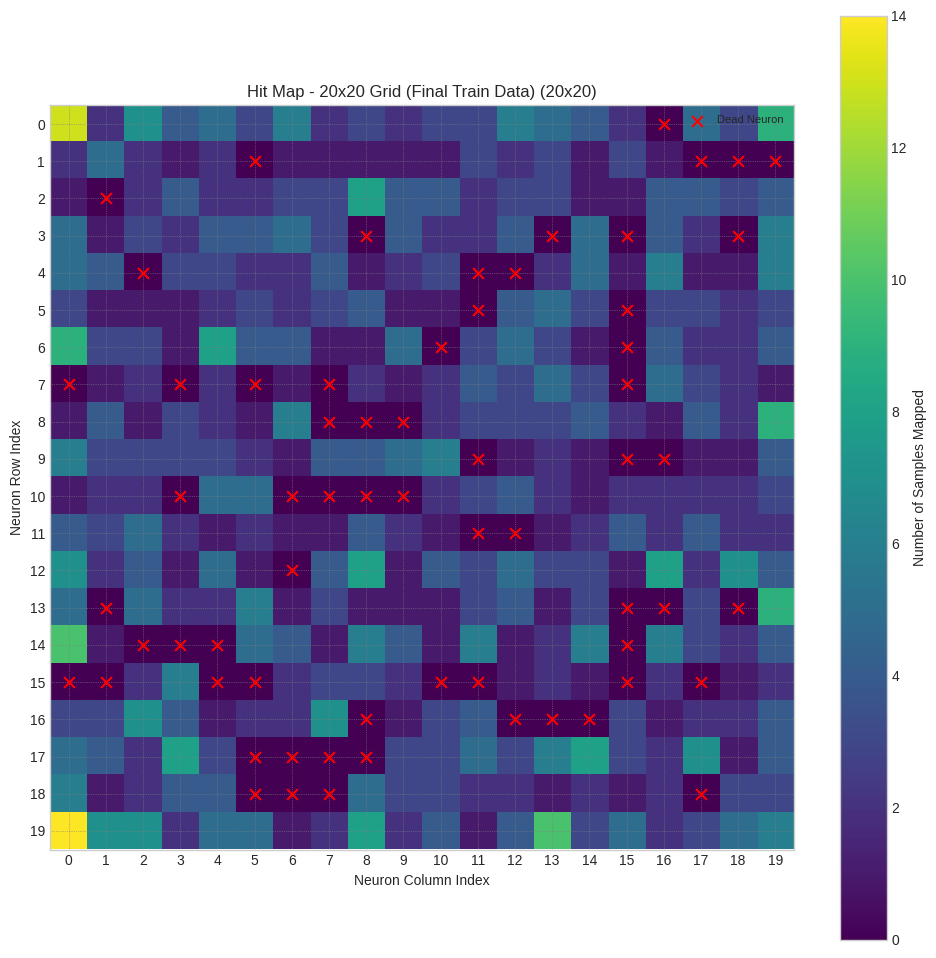


Generating sample images plot for 20x20 Grid (Final Train Data)...
Saved Samples Plot to: images/som_samples_20x20_grid_final_train_data.png


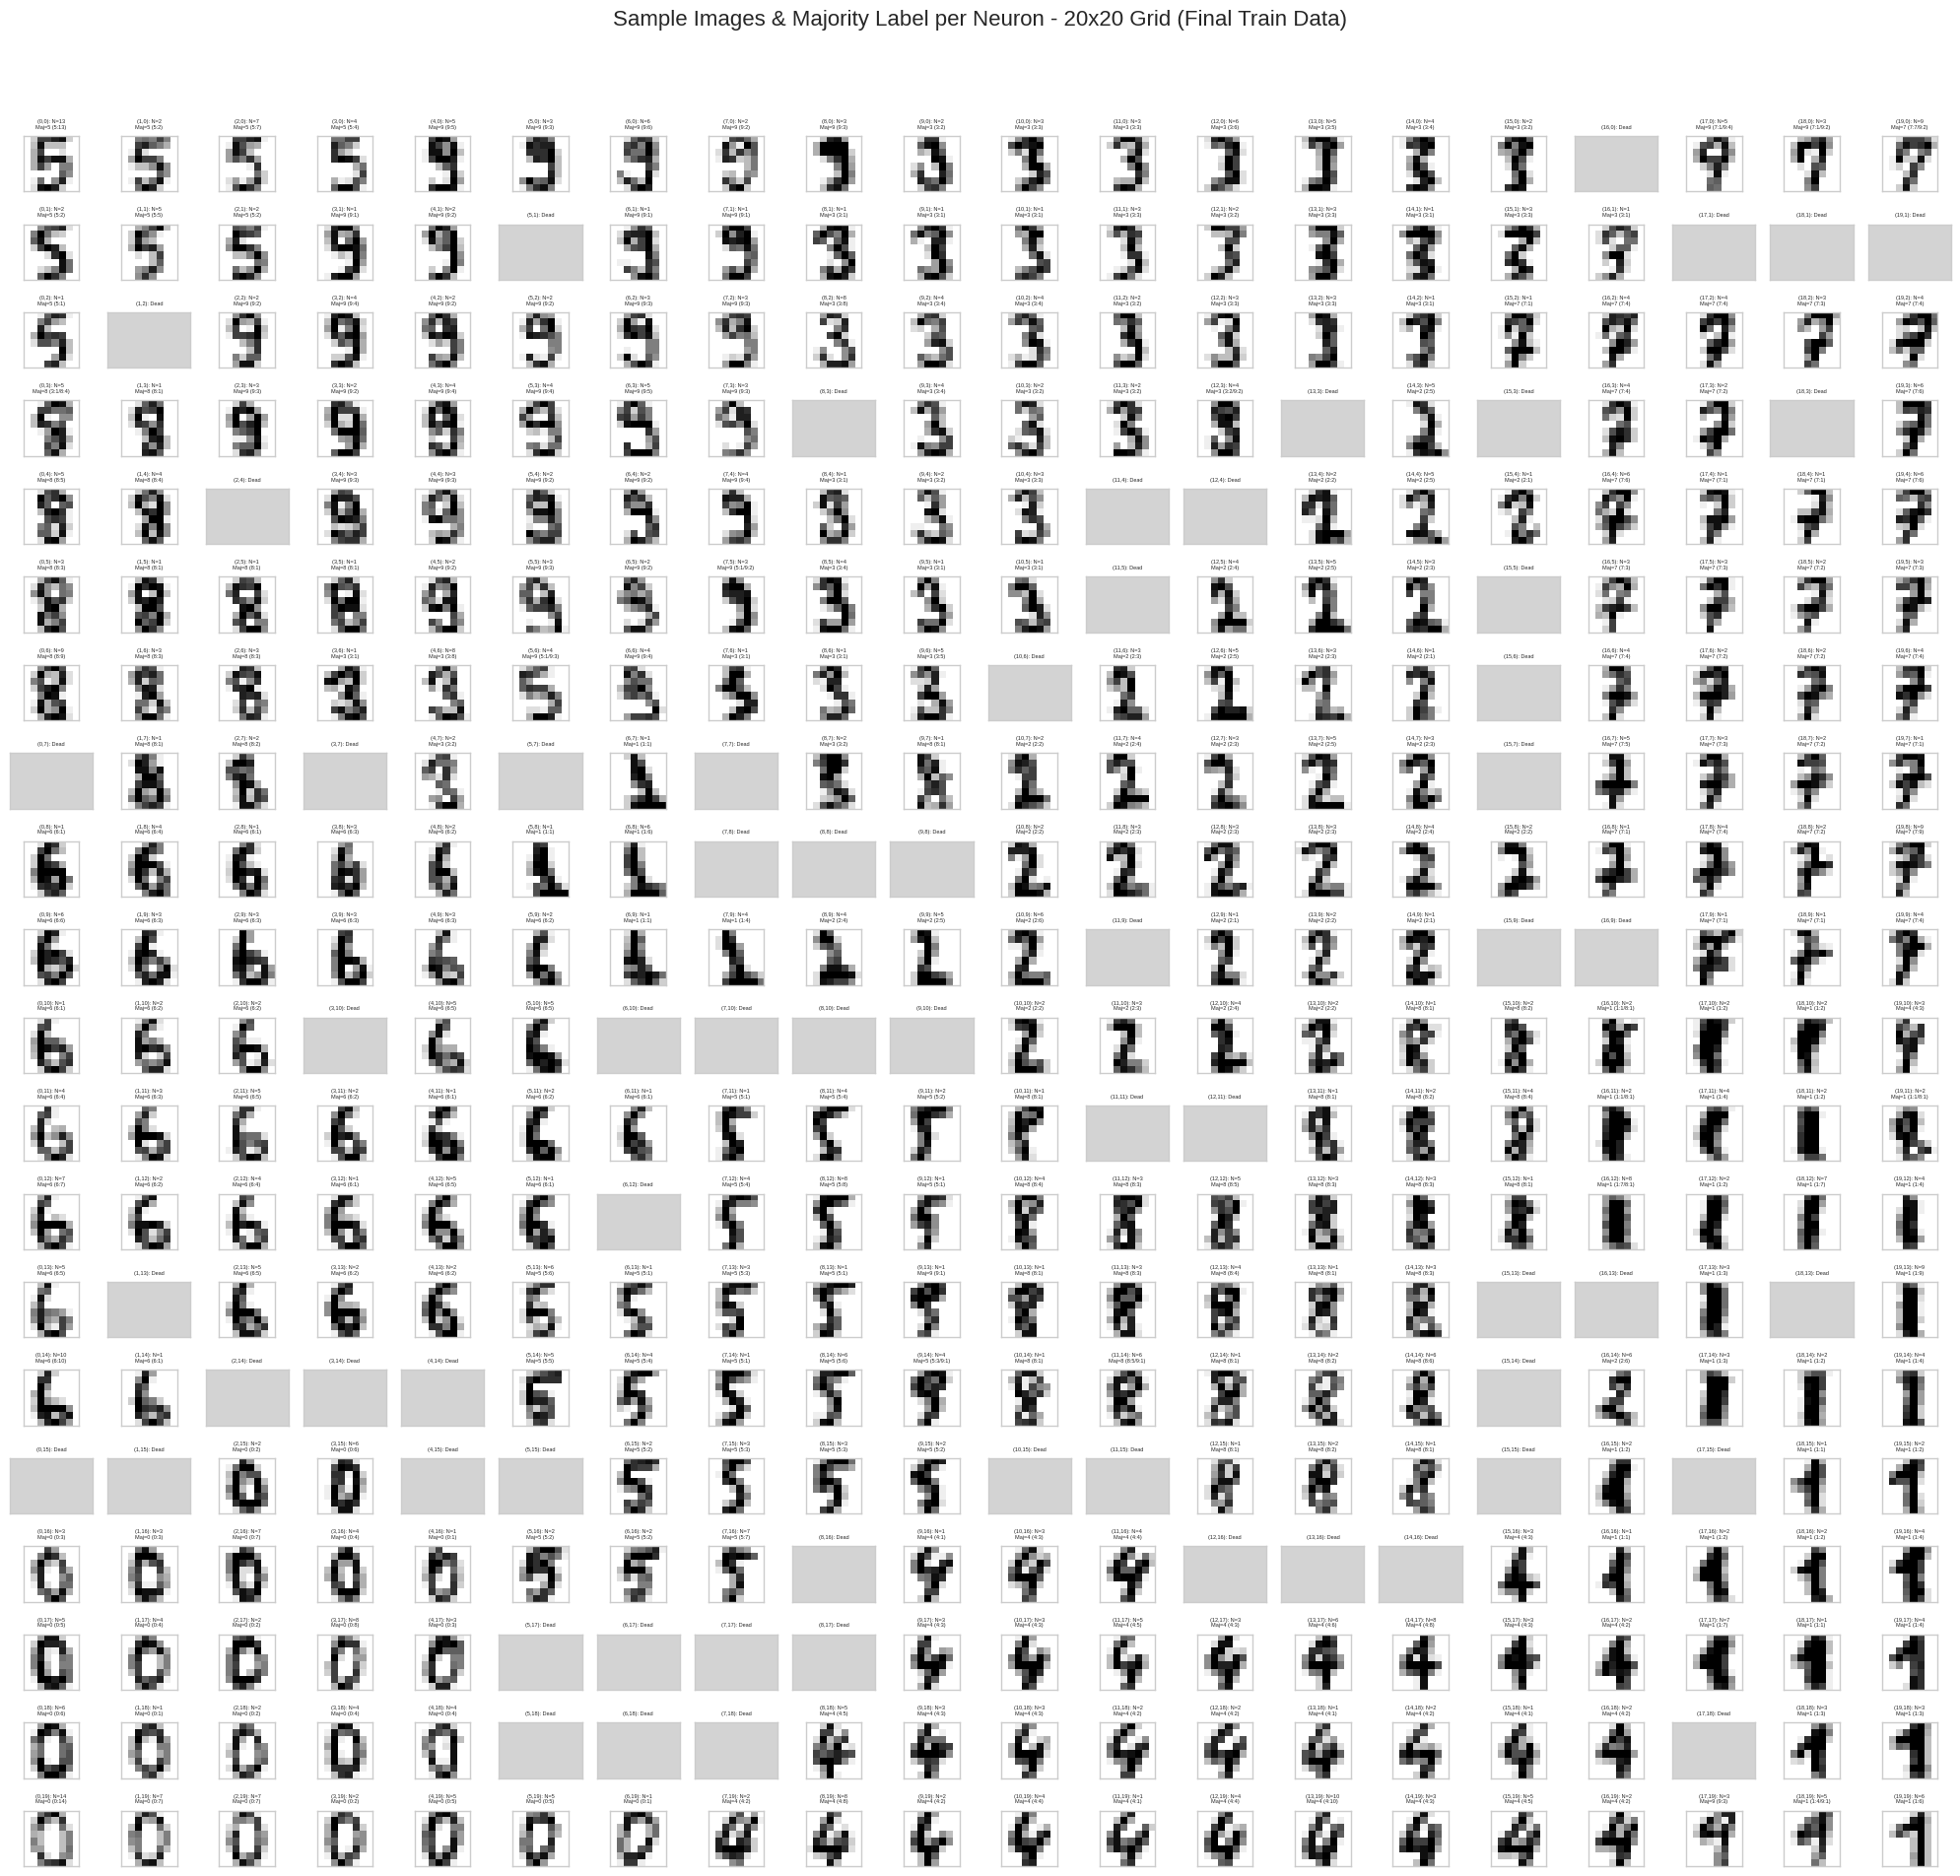

------------------------------


In [16]:
print("\nVisualizing 4x4 SOM based on FINAL Training Data:")
neuron_labels_map_small, dead_neurons_small = visualize_som_clusters(
    som_small, X_train_final, y_train_final, X_train_final_orig,
    som_grid_size_small, "4x4 Grid (Final Train Data)"
)
print("-" * 30)

print("\nVisualizing 20x20 SOM based on FINAL Training Data:")
neuron_labels_map_large, dead_neurons_large = visualize_som_clusters(
    som_large, X_train_final, y_train_final, X_train_final_orig,
    som_grid_size_large, "20x20 Grid (Final Train Data)"
)
print("-" * 30)


## Neuron Labeling Function                                    
  Defines the function assign_labels_to_neurons, which assigns a class label (0-9) to each neuron in the SOM based on the majority class of the training samples that were mapped to it.

In [17]:
print("\n--- Defining Neuron Labeling Function ---")
def assign_labels_to_neurons(neuron_labels_map):
    neuron_class_map = {}
    unlabeled_neurons = 0
    labeled_neurons = 0

    for pos_cr, labels in neuron_labels_map.items():
        if labels:
            try:
                int_labels = [int(l) for l in labels]
                unique_labels, counts = np.unique(int_labels, return_counts=True)
                majority_label = unique_labels[np.argmax(counts)]
                neuron_class_map[pos_cr] = majority_label
                labeled_neurons += 1
            except Exception as e:
                print(f"Warning: Could not assign label for neuron {pos_cr}. "
                      f"Labels: {labels}. Error: {e}")
                unlabeled_neurons += 1
        else:
            unlabeled_neurons += 1

    total_processed = labeled_neurons + unlabeled_neurons
    print(f"Neuron labeling complete: {labeled_neurons} neurons assigned a majority label, "
          f"{unlabeled_neurons} remain unlabeled.")
    return neuron_class_map

print("Neuron labeling function defined.")



--- Defining Neuron Labeling Function ---
Neuron labeling function defined.


## Assigning Neuron Labels
  Applies the labeling function to both the small and large SOMs to determine the digit class that each neuron represents.

In [18]:
print("\nAssigning labels to SOM neurons based on Final Train Data mappings...")

print("\nLabeling Small (4x4) SOM:")
neuron_class_map_small = assign_labels_to_neurons(neuron_labels_map_small)
print("Sample assigned labels (Small SOM):", list(neuron_class_map_small.items())[:5])

print("\nLabeling Large (20x20) SOM:")
neuron_class_map_large = assign_labels_to_neurons(neuron_labels_map_large)
print("Sample assigned labels (Large SOM):", list(neuron_class_map_large.items())[:5])

print("-" * 30)



Assigning labels to SOM neurons based on Final Train Data mappings...

Labeling Small (4x4) SOM:
Neuron labeling complete: 16 neurons assigned a majority label, 0 remain unlabeled.
Sample assigned labels (Small SOM): [((0, 0), np.int64(0)), ((1, 0), np.int64(6)), ((2, 0), np.int64(4)), ((3, 0), np.int64(7)), ((0, 1), np.int64(0))]

Labeling Large (20x20) SOM:
Neuron labeling complete: 336 neurons assigned a majority label, 0 remain unlabeled.
Sample assigned labels (Large SOM): [((0, 0), np.int64(5)), ((1, 0), np.int64(5)), ((2, 0), np.int64(5)), ((3, 0), np.int64(5)), ((4, 0), np.int64(9))]
------------------------------


## Classification and Evaluation Function                         
  Defines the classify_and_evaluate function, which takes a trained and labeled SOM, classifies a given dataset, and calculates performance metrics like accuracy and F1-score. It also generates a confusion matrix and a class map         
  visualization.

In [19]:
def classify_and_evaluate(som, X_test_scaled_eval, y_test_eval,
                          neuron_class_map, dead_neurons_list,
                          grid_size, title):
    print(f"\n--- Classifying and Evaluating: {title} ---")
    rows, cols = grid_size

    predictions = []
    default_pred = -1

    som_weights = som.get_weights()
    num_mapped_to_dead_initially = 0
    num_rescued_by_neighbor = 0
    num_failed_rescue = 0

    print("Classifying test samples...")
    for i, x_test in enumerate(X_test_scaled_eval):
        winner_cr = som.winner(x_test)
        if winner_cr in neuron_class_map:
            predictions.append(neuron_class_map[winner_cr])
        else:
            num_mapped_to_dead_initially += 1
            found_active_neighbor = False

            distances = np.linalg.norm(
                som_weights.reshape(-1, n_features) - x_test,
                axis=1
            )
            sorted_indices = np.argsort(distances)
            for flat_idx in sorted_indices:
                r, c = np.unravel_index(flat_idx, (rows, cols))
                pos_cr = (c, r)
                if pos_cr in neuron_class_map:
                    predictions.append(neuron_class_map[pos_cr])
                    num_rescued_by_neighbor += 1
                    found_active_neighbor = True
                    break

            if not found_active_neighbor:
                predictions.append(default_pred)
                num_failed_rescue += 1

    print("Classification complete.")
    print(f"Info: {num_mapped_to_dead_initially} samples initially hit dead/unlabeled neurons.")
    print(f" {num_rescued_by_neighbor} were assigned label of nearest active neighbor.")
    print(f" {num_failed_rescue} could not find any active neighbor (predicted as {default_pred}).")

    valid_indices = [i for i, p in enumerate(predictions) if p != default_pred]
    num_valid_predictions = len(valid_indices)
    if num_valid_predictions == 0:
        print("Error: All test samples mapped to dead/unlabeled neurons.")
        return 0.0, np.zeros(10), np.zeros(10), np.zeros(10), np.full(grid_size, default_pred)

    print(f"\nEvaluating performance based on {num_valid_predictions} valid predictions "
          f"(out of {len(y_test_eval)} total test samples).")

    y_test_filtered = y_test_eval[valid_indices]
    predictions_filtered = np.array(predictions)[valid_indices]

    accuracy = accuracy_score(y_test_filtered, predictions_filtered)
    print(f"Classification Accuracy ({title}): {accuracy:.4f}")

    class_labels = np.arange(10)
    target_names = [str(i) for i in class_labels]
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test_filtered, predictions_filtered,
        labels=class_labels, zero_division=0
    )

    print("\nClassification Report:")
    report = classification_report(
        y_test_filtered, predictions_filtered,
        labels=class_labels, target_names=target_names,
        zero_division=0
    )
    print(report)

    avg_f1_macro = np.mean(f1)
    print(f"Macro Average F1-score: {avg_f1_macro:.4f}")

    cm = confusion_matrix(y_test_filtered, predictions_filtered, labels=class_labels)
    plt.figure(figsize=(8, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {title}')
    plt.colorbar(label='Number of Samples')
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]:d}",
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=9)
    plt.grid(False)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    # --- NEW: Save Confusion Matrix Figure ---
    safe_title = title.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").lower()
    save_path_cm = os.path.join('images', f'som_cm_{safe_title}.png')
    plt.savefig(save_path_cm)
    print(f"\nSaved Confusion Matrix to: {save_path_cm}")
    plt.show()

    print(f"\nGenerating Neuron Class Map for {title}...")
    plt.figure(figsize=(max(8, cols*0.8), max(6, rows*0.8)))

    class_map_img = np.full((rows, cols), -1.0)
    for pos_cr, label in neuron_class_map.items():
        col, row = pos_cr
        if 0 <= row < rows and 0 <= col < cols:
            class_map_img[row, col] = label

    for pos_cr in dead_neurons_list:
        col, row = pos_cr
        if 0 <= row < rows and 0 <= col < cols:
            if pos_cr not in neuron_class_map:
                class_map_img[row, col] = -1.0

    try:
        cmap_colors = plt.cm.get_cmap('tab10', 10).colors
        cmap_list = [mcolors.to_rgb('lightgrey')] + list(cmap_colors)
        custom_cmap = mcolors.ListedColormap(cmap_list, name='SOMClassMap')
        bounds = np.arange(-1.5, 10.5, 1)
        norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
        cbar_ticks = np.arange(-1, 10)
        cbar_label = 'Assigned Class Label (-1: Dead/Unlabeled)'
    except Exception as e:
        print(f"Warning: Advanced colormap creation failed ({e}). Using simpler fallback.")
        custom_cmap = plt.get_cmap('tab10', 10)
        custom_cmap.set_under('lightgrey')
        norm = mcolors.Normalize(vmin=-1, vmax=9)
        cbar_ticks = np.arange(-1, 10)
        cbar_label = 'Assigned Class Label (approx.)'
# Neuron Class Map Plot
    plt.imshow(class_map_img, cmap=custom_cmap, origin='upper',
               norm=norm, interpolation='nearest')
    plt.colorbar(ticks=cbar_ticks, label=cbar_label)
    plt.title(f'Neuron Class Map - {title}')
    plt.xticks(np.arange(cols))
    plt.yticks(np.arange(rows))
    plt.xlabel("Neuron Column Index")
    plt.ylabel("Neuron Row Index")
    plt.grid(True, which='both', color='black', linewidth=0.5, linestyle=':')

    # --- NEW: Save Neuron Class Map Figure ---
    save_path_class_map = os.path.join('images', f'som_class_map_{safe_title}.png')
    plt.savefig(save_path_class_map)
    print(f"Saved Neuron Class Map to: {save_path_class_map}")
    # --- END NEW ---
    plt.show()

    return accuracy, precision, recall, f1, class_map_img


## Final Model Evaluation
  Evaluates the performance of both the 4x4 and 20x20 SOMs on the held-out final test set, printing classification reports and confusion matrices for each.


--- Evaluating Small (4x4) SOM Classification on FINAL Test Set ---

--- Classifying and Evaluating: 4x4 Grid (Test Set) ---
Classifying test samples...
Classification complete.
Info: 0 samples initially hit dead/unlabeled neurons.
 0 were assigned label of nearest active neighbor.
 0 could not find any active neighbor (predicted as -1).

Evaluating performance based on 360 valid predictions (out of 360 total test samples).
Classification Accuracy (4x4 Grid (Test Set)): 0.8722

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.67      0.97      0.80        36
           2       0.91      0.91      0.91        35
           3       1.00      0.89      0.94        37
           4       0.97      0.89      0.93        36
           5       0.88      0.95      0.91        37
           6       1.00      0.83      0.91        36
           7       0.78      1.00      0.88        36
      

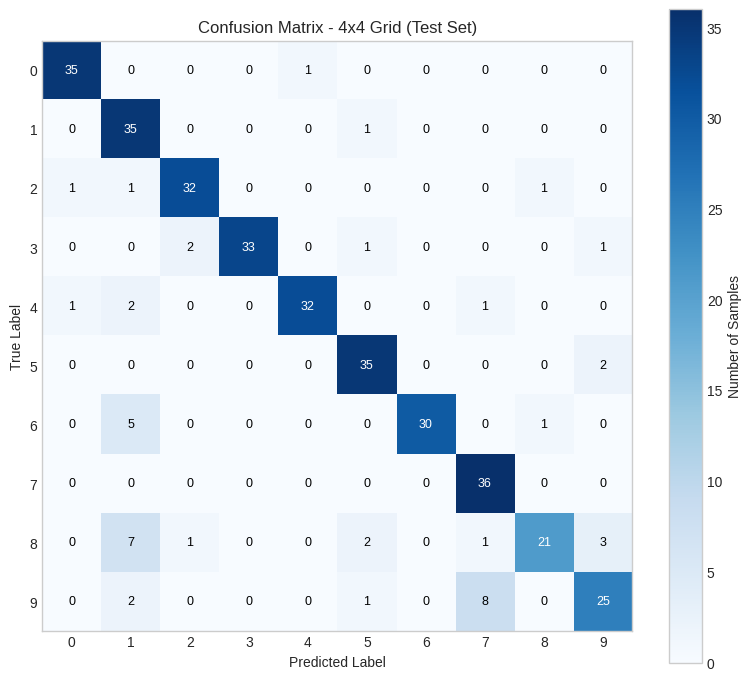


Generating Neuron Class Map for 4x4 Grid (Test Set)...
Saved Neuron Class Map to: images/som_class_map_4x4_grid_test_set.png


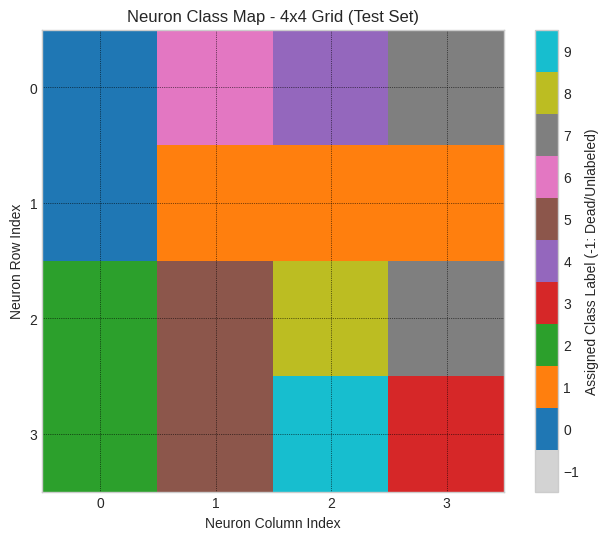

------------------------------

--- Evaluating Large (20x20) SOM Classification on FINAL Test Set ---

--- Classifying and Evaluating: 20x20 Grid (Test Set) ---
Classifying test samples...
Classification complete.
Info: 14 samples initially hit dead/unlabeled neurons.
 14 were assigned label of nearest active neighbor.
 0 could not find any active neighbor (predicted as -1).

Evaluating performance based on 360 valid predictions (out of 360 total test samples).
Classification Accuracy (20x20 Grid (Test Set)): 0.9278

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.88      0.97      0.92        36
           2       0.94      0.97      0.96        35
           3       0.88      0.97      0.92        37
           4       0.97      0.97      0.97        36
           5       0.95      1.00      0.97        37
           6       0.97      0.83      0.90        36
           7       0.

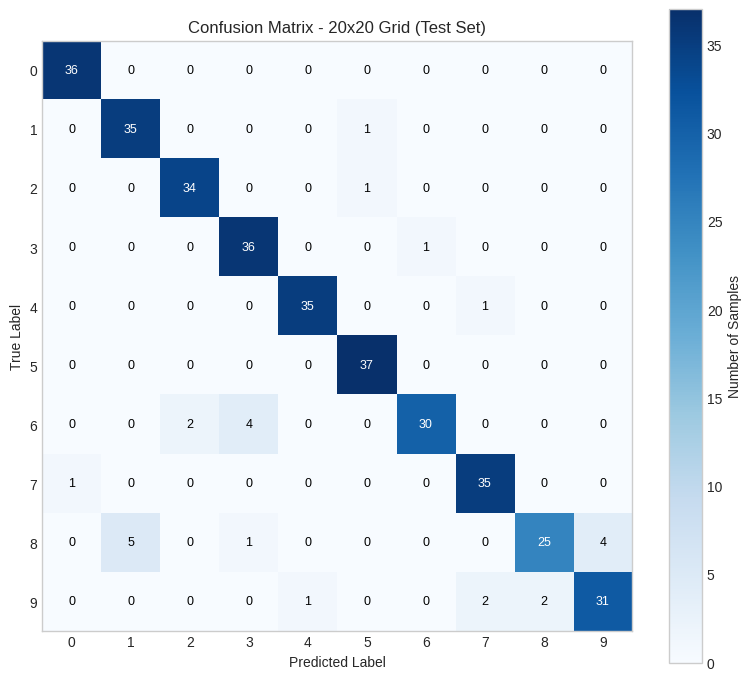


Generating Neuron Class Map for 20x20 Grid (Test Set)...
Saved Neuron Class Map to: images/som_class_map_20x20_grid_test_set.png


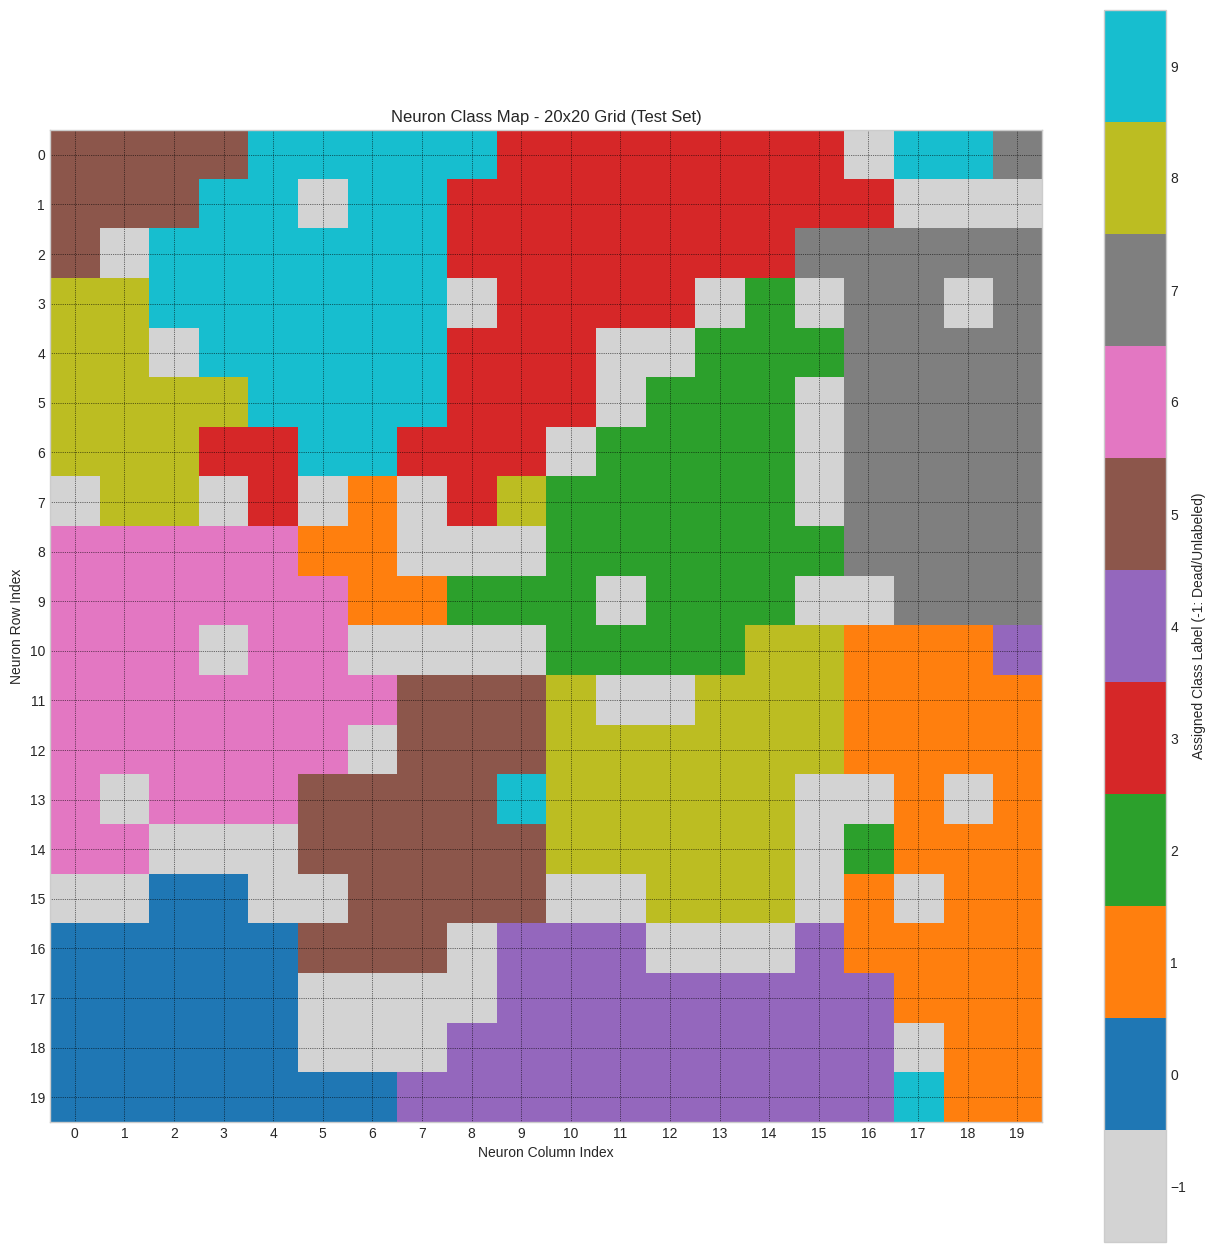

------------------------------


In [20]:
print("\n--- Evaluating Small (4x4) SOM Classification on FINAL Test Set ---")
accuracy_small, precision_small, recall_small, f1_small, class_map_small_img = classify_and_evaluate(
    som_small, X_test, y_test,
    neuron_class_map_small, dead_neurons_small,
    som_grid_size_small, "4x4 Grid (Test Set)"
)
print("-" * 30)

print("\n--- Evaluating Large (20x20) SOM Classification on FINAL Test Set ---")
accuracy_large, precision_large, recall_large, f1_large, class_map_large_img = classify_and_evaluate(
    som_large, X_test, y_test,
    neuron_class_map_large, dead_neurons_large,
    som_grid_size_large, "20x20 Grid (Test Set)"
)
print("-" * 30)

## Performance Comparison  

In [21]:

print("\n--- Final Comparison of SOM Classification Results (on Test Set) ---")
avg_f1_small = np.mean(f1_small) if f1_small.size > 0 else 0.0
avg_f1_large = np.mean(f1_large) if f1_large.size > 0 else 0.0

print("Metric           | 4x4 Grid | 20x20 Grid | Comparison")
print("--------------   |----------|-----------|-----------")
print(f"Accuracy         | {accuracy_small:.4f} | {accuracy_large:.4f} | "
      f"{'Large SOM better' if accuracy_large > accuracy_small else ('Small SOM better' if accuracy_small > accuracy_large else 'Equal')}")
print(f"Macro Avg F1     | {avg_f1_small:.4f} | {avg_f1_large:.4f} | "
      f"{'Large SOM better' if avg_f1_large > avg_f1_small else ('Small SOM better' if avg_f1_small > avg_f1_large else 'Equal')}")
print("-" * 60)



--- Final Comparison of SOM Classification Results (on Test Set) ---
Metric           | 4x4 Grid | 20x20 Grid | Comparison
--------------   |----------|-----------|-----------
Accuracy         | 0.8722 | 0.9278 | Large SOM better
Macro Avg F1     | 0.8706 | 0.9255 | Large SOM better
------------------------------------------------------------
